# <font size=14>Clustering Similar Neighborhoods in Toronto using K-means Clustering</font>


# Add geographical coordinates to neighborhood dataframe

### In this section, our objective is to get the latitude and longitude of each neighborhood and put them into two separate columns in the neighborhood dataframe that we created earlier.

We will use `ArcGIS` module of `geopy` package. First, we have to create an instance of geocoder which we will use later to call the API and get our results.

In [ ]:
from geopy.geocoders import ArcGIS

geolocator = ArcGIS()

We will take in neighborhood names and postal codes and pass them into the geocoder instance for fetching latitude and longitude values. Then the values will be added to the original dataframe in two separate columns.

In [ ]:
# function for getting geo coordinates
def get_lat_long(row):

    postal_code = row['PostalCode']
    neighborhoods = row['Neighborhood']

    # make the address with neighborhoods and postal code to get a better match
    address = f'{neighborhoods}, Toronto, Ontario {postal_code}, CAN'

    # timeout value is set to avoid geocoding api default timeout limit in the middle of fetching
    result = geolocator.geocode(address, timeout=10000)

    latitude = result.latitude
    longitude = result.longitude

    return latitude, longitude

In [ ]:
neigh_df['Latitude'], neigh_df['Longitude'] = zip(*neigh_df.apply(get_lat_long, axis=1))

In [ ]:
neigh_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.751880,-79.330360
1,M4A,North York,Victoria Village,43.730420,-79.312820
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.659743,-79.361561
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.714925,-79.449739
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.664490,-79.393020


# Explore and cluster neighborhoods in Toronto

### Our objecive here is to visualize the Toronto city neighborhood in a map using `folium` library and then cluster the neigborhoods based on most common venue categories. We will use `foursquare` api to get the venues around a neighborhood and `k-means` as the clustering algorithm.

#### We have the neighborhood coordinates in our dataframe. Lets first visualize the neighborhoods in a map using the coordinates.

In [ ]:
import folium

Get the latitude and longitude of Toronto as we need to center our map on Toronto city.

In [ ]:
address = 'Toronto, Ontario, Canada'

location = geolocator.geocode(address)

toronto_lat = location.latitude
toronto_long = location.longitude
print(f'The geograpical coordinate of Toronto are {toronto_lat}, {toronto_long}')

The geograpical coordinate of Toronto are 43.648690000000045, -79.38543999999996


Plot the map of neighborhoods in Toronto with labels.

In [ ]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[toronto_lat, toronto_long], zoom_start=10.5)

# add markers to map
for lat, lng, borough, neighborhood in zip(neigh_df['Latitude'], neigh_df['Longitude'], neigh_df['Borough'], neigh_df['Neighborhood']):
    label = f'{neighborhood}, {borough}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto) 

# limit height of scrollable output window
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 650})'''))

map_toronto

<IPython.core.display.Javascript object>

#### Now we will use foursqare api to get the list of venues around a neighborhood and visualize the venues in map. 

In [ ]:
from datetime import datetime

# get the date for use in VERSION parameter of fousqare api call
today = datetime.today().strftime('%Y%m%d')
today

'20200918'

Define foursqare credentials and VERSION.

In [ ]:
CLIENT_ID = 'PU2X5P44NV3LCALJVKNYCSOIUCZFE2PV2XH2RMOHFZPLL0W4' # my Foursquare ID
CLIENT_SECRET = 'LG54WFPRXM4VOQEEVMZ0U3HG3ILITU23TKG3AXFHVFNB3PCV' # my Foursquare Secret
VERSION = today # Foursquare API version, format='YYYYMMDD'

Lets create a function that will iterate over the neighborhoods and get the venues around them using foursqaure api. The venue information will be stored in a dataframe.

In [ ]:
LIMIT = 100 # maximum number of venues to be returned

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # add only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now using our neighborhood dataframe, we will call `getNearbyVenues()` and create a newdataframe of toronto neighborhood venues.

In [ ]:
toronto_venues = getNearbyVenues(names=neigh_df['Neighborhood'],
                                   latitudes=neigh_df['Latitude'],
                                   longitudes=neigh_df['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

Check how many venues did we get and see a part of our dataframe.

In [ ]:
print('Total number of venues:', toronto_venues.shape[0])
toronto_venues.head()

Total number of venues: 2315


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.75188,-79.33036,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.75188,-79.33036,PetSmart,43.748639,-79.333488,Pet Store
2,Parkwoods,43.75188,-79.33036,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.73042,-79.31282,Memories of Africa,43.726602,-79.312427,Grocery Store
4,Victoria Village,43.73042,-79.31282,Eglinton Ave E & Sloane Ave/Bermondsey Rd,43.726086,-79.313620,Intersection


Let's check how many venues were returned for each neighborhood.

In [ ]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Alderwood, Long Branch",5,5,5,5,5,5
"Bathurst Manor, Wilson Heights, Downsview North",3,3,3,3,3,3
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",2,2,2,2,2,2
Berczy Park,100,100,100,100,100,100
...,...,...,...,...,...,...
"Willowdale, Willowdale West",2,2,2,2,2,2
Woburn,4,4,4,4,4,4
Woodbine Heights,6,6,6,6,6,6


Let's find out how many unique categories can be curated from all the returned venues.

In [ ]:
unique = len(toronto_venues['Venue Category'].unique())
print(f'There are {unique} uniques categories.')

There are 265 uniques categories.


Now we will visualize the venues in map and also we will cluster them as well otherwise the map would be very congested.

In [ ]:
from folium import plugins

venue_map = folium.Map(location=[toronto_lat, toronto_long], zoom_start=10.5)

# instantiate a marker cluster object for the venues in the dataframe
venues = plugins.MarkerCluster().add_to(venue_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(toronto_venues['Venue Latitude'], toronto_venues['Venue Longitude'], toronto_venues['Venue']):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(venues)

# limit height of scrollable output window
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 650})'''))

# display map
venue_map

<IPython.core.display.Javascript object>

#### Preprocess the data for use in k-means.

Apply one hot encoding to venue catogories.

In [ ]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
neigh = toronto_onehot.pop('Neighborhood')
toronto_onehot.insert(0, neigh.name, neigh)

toronto_onehot.head()

,Neighborhood,Accessories Store,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,...,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Steakhouse,Street Art,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [ ]:
toronto_onehot.shape

(2315, 265)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [ ]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Accessories Store,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,...,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Steakhouse,Street Art,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.00
1,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.333333,0.00
2,Bayview Village,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.00
3,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.500000,0.00
4,Berczy Park,0.0,0.0,0.0,0.0,0.01,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.03,0.0,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.000000,0.01


Let's confirm the new size.

In [ ]:
toronto_grouped.shape

(97, 265)

Now we will get the 10 most common venue categories for each neighborhood and put them into a dataframe.

In [ ]:
# function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues = 10

suffixes = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for i in np.arange(num_top_venues):
    try:
        columns.append(f'{i+1}{suffixes[i]} Most Common Venue')
    except:
        columns.append(f'{i+1}th Most Common Venue')

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

# number of rows in neighborhood venue catagories dataframe
num_rows = toronto_grouped.shape[0]

for ind in np.arange(num_rows):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Alderwood, Long Branch",Pizza Place,Convenience Store,Pub,Gym,Sandwich Place,Event Space,Ethiopian Restaurant,Escape Room,Falafel Restaurant,Distribution Center
1,"Bathurst Manor, Wilson Heights, Downsview North",Women's Store,Park,IT Services,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Doner Restaurant,Fish & Chips Shop
2,Bayview Village,Construction & Landscaping,Trail,Golf Driving Range,Park,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room
3,"Bedford Park, Lawrence Manor East",Women's Store,Lawyer,Donut Shop,Fish Market,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
4,Berczy Park,Coffee Shop,Restaurant,Café,Italian Restaurant,Hotel,Japanese Restaurant,Gastropub,Breakfast Spot,Beer Bar,Seafood Restaurant


#### Now, we will use the `k-means` algorithm to cluster neighborhoods based on venue categories. We will also visualize the clusters in map.

First find the best `k` value for our data based on accuracy.

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

There are basically two methods for finding the optimal k. They are:


1.   The Elbow Method
2.   The Silhouette Method

More on these can be learned from [here.](https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb)

We will use the elbow method first.

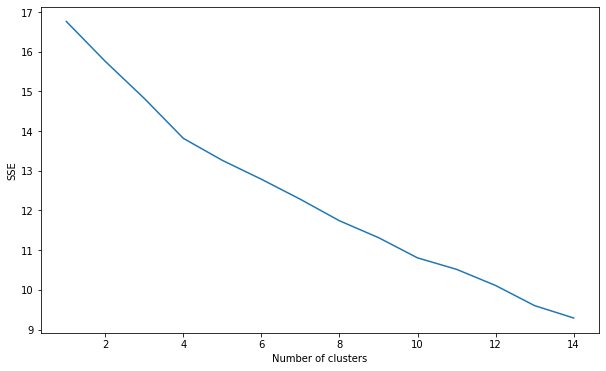

In [ ]:
# remove the neighborhood column
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=69).fit(toronto_grouped_clustering)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

As the elbow is somewhat ambigous here, lets use the silhouette method now.

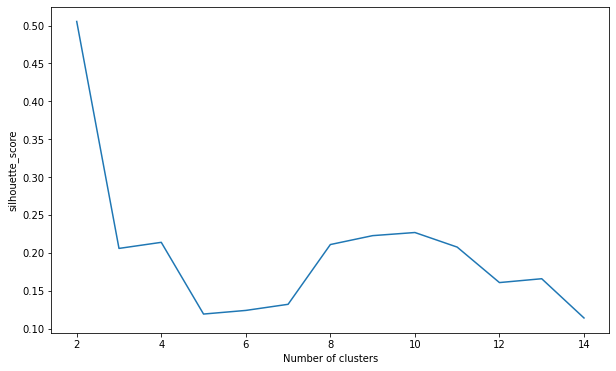

In [ ]:
from sklearn.metrics import silhouette_score

sil_coeff = {}

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=69).fit(toronto_grouped_clustering)
    label = kmeans.labels_
    sil_coeff[k] = silhouette_score(toronto_grouped_clustering, label, metric='euclidean')

plt.figure(figsize=(10, 6))
plt.plot(list(sil_coeff.keys()), list(sil_coeff.values()))
plt.xlabel("Number of clusters")
plt.ylabel("silhouette_score")
plt.show()

We can see that `k=2` has got the highest silhouette_score and also there's an elbow at `k=2` in elbow method. So, we will take **`k=2`** as our number of clusters.

In [ ]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=69).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [ ]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [ ]:
toronto_merged = neigh_df

toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# remove postal code, we don't need it anymore
toronto_merged.drop('PostalCode', axis=1, inplace=True)

toronto_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,Parkwoods,43.751880,-79.330360,0.0,Park,Food & Drink Shop,Pet Store,Ethiopian Restaurant,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Yoga Studio
1,North York,Victoria Village,43.730420,-79.312820,1.0,Grocery Store,Intersection,Yoga Studio,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room
2,Downtown Toronto,"Regent Park, Harbourfront",43.659743,-79.361561,1.0,Coffee Shop,Thai Restaurant,Pub,Indian Restaurant,Sushi Restaurant,Pool,Restaurant,Auto Dealership,Food Truck,Park
3,North York,"Lawrence Manor, Lawrence Heights",43.714925,-79.449739,1.0,Coffee Shop,Fast Food Restaurant,Restaurant,Pet Store,Bus Line,Mobile Phone Shop,Flower Shop,Bookstore,Moving Target,Sandwich Place
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.664490,-79.393020,1.0,Coffee Shop,Café,Park,Sandwich Place,Music Store,Burger Joint,Salon / Barbershop,Chinese Restaurant,Restaurant,Lake


In [ ]:
toronto_merged['Cluster Labels'].value_counts()

1.0    89
0.0    11
2.0     1
Name: Cluster Labels, dtype: int64

Drop any row having NaN values.

In [ ]:
toronto_merged.dropna(inplace=True)

In [ ]:
toronto_merged['Cluster Labels'].isnull().any()

False

Finally, let's visualize the resulting clusters.

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [ ]:
cluster_map = folium.Map(location=[toronto_lat, toronto_long], zoom_start=10.5)

kclusters = 8
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    cluster = int(cluster)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(cluster_map)

# limit height of scrollable output window
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 650})'''))

cluster_map

<IPython.core.display.Javascript object>

To avoid congestion, lets clusterize the labels.

In [ ]:
cluster_map = folium.Map(location=[toronto_lat, toronto_long], zoom_start=10.5)

# instantiate a marker cluster object for the venues in the dataframe
clusters = plugins.MarkerCluster().add_to(cluster_map)

kclusters = 8
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    cluster = int(cluster)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(clusters)

# limit height of scrollable output window
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 650})'''))

cluster_map

<IPython.core.display.Javascript object>

Lets examine some representative neighborhoods from each cluster.

Cluster 1

In [ ]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,Park,Food & Drink Shop,Pet Store,Ethiopian Restaurant,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Yoga Studio
22,Woburn,Construction & Landscaping,Business Service,Park,Coffee Shop,Ethiopian Restaurant,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room
26,Cedarbrae,Park,Grocery Store,Playground,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Dog Run,Escape Room
28,"Bathurst Manor, Wilson Heights, Downsview North",Women's Store,Park,IT Services,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Doner Restaurant,Fish & Chips Shop
39,Bayview Village,Construction & Landscaping,Trail,Golf Driving Range,Park,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room
68,"Forest Hill North & West, Forest Hill Road Park",Jewelry Store,Sushi Restaurant,Gym / Fitness Center,Park,Trail,Escape Room,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
69,"High Park, The Junction South",Park,Convenience Store,Gym / Fitness Center,Residential Building (Apartment / Condo),Tennis Court,Italian Restaurant,Café,Baseball Field,Ethiopian Restaurant,Event Space
72,"Willowdale, Willowdale West",Park,Mobile Phone Shop,Event Space,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Yoga Studio
73,"North Toronto West, Lawrence Park",Playground,Gym Pool,Garden,Park,Farmers Market,Falafel Restaurant,Event Space,Fast Food Restaurant,Ethiopian Restaurant,Dog Run
94,"Northwest, West Humber - Clairville",Paper / Office Supplies Store,Skating Rink,Disc Golf,Park,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Yoga Studio


Cluster 2

In [ ]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Victoria Village,Grocery Store,Intersection,Yoga Studio,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room
2,"Regent Park, Harbourfront",Coffee Shop,Thai Restaurant,Pub,Indian Restaurant,Sushi Restaurant,Pool,Restaurant,Auto Dealership,Food Truck,Park
3,"Lawrence Manor, Lawrence Heights",Coffee Shop,Fast Food Restaurant,Restaurant,Pet Store,Bus Line,Mobile Phone Shop,Flower Shop,Bookstore,Moving Target,Sandwich Place
4,"Queen's Park, Ontario Provincial Government",Coffee Shop,Café,Park,Sandwich Place,Music Store,Burger Joint,Salon / Barbershop,Chinese Restaurant,Restaurant,Lake
5,"Islington Avenue, Humber Valley Village",Pharmacy,Bank,Grocery Store,Café,Shopping Mall,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Doner Restaurant


Cluster 3

In [ ]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
45,"York Mills, Silver Hills",Martial Arts School,Yoga Studio,Doner Restaurant,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
